## [Survival Analysis with Kaplan Meier and Box plot]
Here I use Python to analyze a dataset of duration of survival time after a heart attack and visualize the finding with Kaplan Meier and Box plot in aiming to following questions, 
1. How long a patient have got to live after a heart attack happend?
2. Does patient's age affect duration of survival time after a heart attack?
3. What is median survival duration of patients who are above and below age of 62?

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statistics
from sklearn.impute import SimpleImputer
from lifelines import KaplanMeierFitter, CoxPHFitter
from lifelines.statistics import logrank_test
from scipy import stats

## [Step 1] Get the dataset

In [2]:
df = pd.read_csv("echocardiogram.csv")
df.head(5)

,survival,alive,age,pericardialeffusion,fractionalshortening,epss,lvdd,wallmotion-score,wallmotion-index,mult,name,group,aliveat1
0,11.0,0.0,71.0,0.0,0.260,9.000,4.600,14.0,1.00,1.000,name,1,0.0
1,19.0,0.0,72.0,0.0,0.380,6.000,4.100,14.0,1.70,0.588,name,1,0.0
2,16.0,0.0,55.0,0.0,0.260,4.000,3.420,14.0,1.00,1.000,name,1,0.0
3,57.0,0.0,60.0,0.0,0.253,12.062,4.603,16.0,1.45,0.788,name,1,0.0
4,19.0,1.0,57.0,0.0,0.160,22.000,5.750,18.0,2.25,0.571,name,1,0.0


## [Step 2] Preparing data to be ready for analysis

In [3]:
# 2-1: Checking if there is any null values
print(df.isnull().sum())

survival                 3
alive                    2
age                      7
pericardialeffusion      1
fractionalshortening     9
epss                    16
lvdd                    12
wallmotion-score         5
wallmotion-index         3
mult                     4
name                     2
group                   23
aliveat1                58
dtype: int64


In [4]:
# 2-2: Replacing missing values and replace them with mean values
mean = SimpleImputer(missing_values = np.nan, strategy = 'mean')
Columns = ['age', 'pericardialeffusion', 'fractionalshortening', 'epss', 'lvdd', 'wallmotion-score']
X = mean.fit_transform(df[Columns])
df_X = pd.DataFrame(X, columns = Columns)
keep = ['survival', 'alive']
df_keepcolumn = df[keep]
df = pd.concat([df_keepcolumn, df_X], axis = 1)
df = df.dropna() 
print(df.isnull().sum())
print(df.shape)

survival                0
alive                   0
age                     0
pericardialeffusion     0
fractionalshortening    0
epss                    0
lvdd                    0
wallmotion-score        0
dtype: int64
(130, 8)


In [5]:
# 2-3: Take a look how Dataframe looks like.
df.head(5)

,survival,alive,age,pericardialeffusion,fractionalshortening,epss,lvdd,wallmotion-score
0,11.0,0.0,71.0,0.0,0.260,9.000,4.600,14.0
1,19.0,0.0,72.0,0.0,0.380,6.000,4.100,14.0
2,16.0,0.0,55.0,0.0,0.260,4.000,3.420,14.0
3,57.0,0.0,60.0,0.0,0.253,12.062,4.603,16.0
4,19.0,1.0,57.0,0.0,0.160,22.000,5.750,18.0


In [6]:
# 2-4: Create a new column. Istead of using 'Alive', we use 'dead' so 0 means not dead, 1 means dead

df.loc[df.alive == 1, 'dead'] = 0
df.loc[df.alive == 0, 'dead'] = 1
df.groupby('dead').count()

,survival,alive,age,pericardialeffusion,fractionalshortening,epss,lvdd,wallmotion-score
dead,,,,,,,,
0.0,42,42,42,42,42,42,42,42
1.0,88,88,88,88,88,88,88,88


## [Step 3] Analyze data with KaplanMeierFitter( ) and plot a Kaplan Meier figure

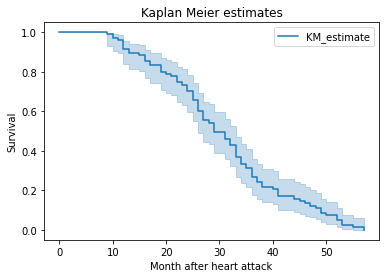

In [7]:
# 3-1: we plot dataset with Kaplan Meier
kmf = KaplanMeierFitter()
X= df['survival']
Y = df['dead']
kmf.fit(X, event_observed = Y)
kmf.plot()
plt.title("Kaplan Meier estimates")
plt.xlabel("Month after heart attack")
plt.ylabel("Survival")
plt.show()


In [8]:
# 3-2: work out what is average survival time of patients after heart attack inicident
print("The median survival time :",kmf.median_survival_time_)

The median survival time : 29.0


### QUESTION 1: 
How long a patient have got to live after a heart attack happend?

### ANSWER: 
From the caculation above we can say average survival time of patients is 29 months

## [Step 4] Find out if a patient's age affect duration of survival time after a heart attack?

Text(0, 0.5, 'Survival')

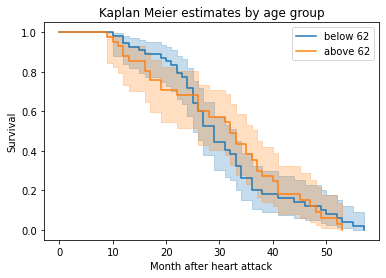

In [9]:
# 4-2: plot by age groups
age_group = df['age'] < statistics.median(df['age'])
ax = plt.subplot(111)

# age below 62 years-old
kmf.fit(X[age_group], event_observed = Y[age_group], label = 'below 62')
kmf.plot(ax = ax)

# age above 62 years-old
kmf.fit(X[~age_group], event_observed = Y[~age_group], label = 'above 62')
kmf.plot(ax = ax)

# Plot labels
plt.title("Kaplan Meier estimates by age group")
plt.xlabel("Month after heart attack")
plt.ylabel("Survival")

### QUESTION 2: 
Does patient's age affect duration of survival time after a heart attack?

### ANSWER: 
we can see age group below 62 has higher survival rate for 24 months. From that point on and up to 48 months age group above 62 has better survival rate. After 48 month, both groups has similar survival rate. 

## [Step 5] Plot survival rate in Boxplot by age groups

In [11]:
# 5-1: First I create a new column for specifying patients' age group
bins= [0,63,110]
labels = ['Group 1','Group 2']
df['AgeGroup'] = pd.cut(df['age'], bins=bins, labels=labels, right=False)
df

,survival,alive,age,pericardialeffusion,fractionalshortening,epss,lvdd,wallmotion-score,dead,AgeGroup
0,11.0,0.0,71.0,0.0,0.260,9.000,4.600,14.0,1.0,Group 2
1,19.0,0.0,72.0,0.0,0.380,6.000,4.100,14.0,1.0,Group 2
2,16.0,0.0,55.0,0.0,0.260,4.000,3.420,14.0,1.0,Group 1
3,57.0,0.0,60.0,0.0,0.253,12.062,4.603,16.0,1.0,Group 1
4,19.0,1.0,57.0,0.0,0.160,22.000,5.750,18.0,0.0,Group 1
...,...,...,...,...,...,...,...,...,...,...
128,7.5,1.0,64.0,0.0,0.240,12.900,4.720,12.0,0.0,Group 2
129,41.0,0.0,64.0,0.0,0.280,5.400,5.470,11.0,1.0,Group 2
130,36.0,0.0,69.0,0.0,0.200,7.000,5.050,14.5,1.0,Group 2
131,22.0,0.0,57.0,0.0,0.140,16.100,4.360,15.0,1.0,Group 1


Text(0, 0.5, 'Survival')

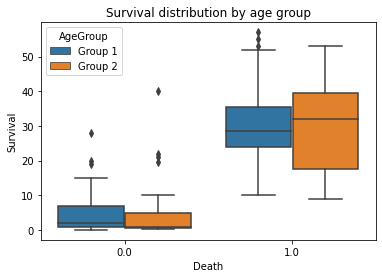

In [15]:
# 5-2: create grouped boxplot and see data distributions
sns.boxplot(x = df['dead'],
            y = df['survival'],
            hue = df['AgeGroup'])

# Plot labels
plt.title("Survival distribution by age group")
plt.xlabel("Death")
plt.ylabel("Survival")

From the Box plot on Death = 1, we can see People under age 62-years old (Group 1) has lower median survival duration

In [13]:
# 5-3: Work out excat median values
X_Y= df.loc[df.AgeGroup=='Group 1']
X= X_Y['survival']
Y= X_Y['dead']
kmf.fit(X, event_observed = Y)
print("The median survival time for Group 1 :",kmf.median_survival_time_)

The median survival time for Group 1 : 29.0


In [14]:
XA_YB= df.loc[df.AgeGroup=='Group 2']
# XA_YB= df.sort_values('survival')['survival'].unique()
X= XA_YB['survival']
Y = XA_YB['dead']
kmf.fit(X, event_observed = Y)
print("The median survival time for Group 2 :",kmf.median_survival_time_)

The median survival time for Group 2 : 33.0


### QUESTION 3:
What is median survival duration of patients who are above and below age of 62?

### ANSWER:
The median survival time for Group 1 (Age below 62) : 29.0
The median survival time for Group 2 (Age above 62): 33.0
whcih is same result that we got from the box plot